In [1]:
import numpy as np
import librosa
import random
import sys
import os
import torch
import scipy.signal as sig
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

DATASET_EVENT_DURATION_SECS = 2
SAMPLE_DURATION_SECS = 1
UNIFORM_SAMPLE_RATE = 20000

MAX_FILES_PER_CLASS = 10
MAX_EVENTS_PER_FILE = 10
MAX_EVENTS_PER_CLASS = 100

def load_dataset_file(path: str):
    p = path.rfind('.')
    if p >= 0: path = path[:p]

    try:
        orig_samples, orig_sr = librosa.load(f'{path}.wav', sr = None)
        new_samples = librosa.resample(orig_samples, orig_sr = orig_sr, target_sr = UNIFORM_SAMPLE_RATE)
    except Exception as e:
        print(f'failed to read {path}.wav', file = sys.stderr)
        raise e

    raw_events = []
    with open(f'{path}.meta', 'r') as f:
        for line in f:
            vals = [x.strip() for x in line.strip().split(',')]
            if len(vals) == 2:
                vals = ['TRAIN', *vals]
            assert len(vals) == 3
            if vals[2].lower() == 'ignore': continue
            vals[1] = round(int(vals[1]) * (UNIFORM_SAMPLE_RATE / orig_sr))
            raw_events.append(vals)
    raw_events.sort(key = lambda x: x[1])

    res = []
    t = 0
    dt = round(SAMPLE_DURATION_SECS * UNIFORM_SAMPLE_RATE)
    edt = round(DATASET_EVENT_DURATION_SECS * UNIFORM_SAMPLE_RATE)
    while True:
        if t + dt > new_samples.shape[0]: break
        label = 'ignore'
        for raw_event in raw_events:
            if t + dt > raw_event[1] and t < raw_event[1] + edt:
                label = raw_event[2]
                break
        res.append((label, new_samples[t:t+dt]))
        t += dt
    return res

def get_dataset():
    dataset = {}
    for dirpath, dirnames, filenames in os.walk('dataset-partial'):
        random.shuffle(filenames)
        for i, filename in enumerate(filenames):
            if i >= MAX_FILES_PER_CLASS or not filename.endswith('.wav'): continue
            sub_dataset = {}
            for label, data in load_dataset_file(f'{dirpath}/{filename}'):
                if label not in sub_dataset:
                    sub_dataset[label] = []
                sub_dataset[label].append(data)
            for k, v in sub_dataset.items():
                random.shuffle(v)
                if k not in dataset:
                    dataset[k] = []
                dataset[k].extend(v)
    for k in dataset.keys():
        random.shuffle(dataset[k])
        if len(dataset[k]) > MAX_EVENTS_PER_CLASS:
            dataset[k] = dataset[k][:MAX_EVENTS_PER_CLASS]
    return dataset

train = get_dataset()
test = get_dataset()

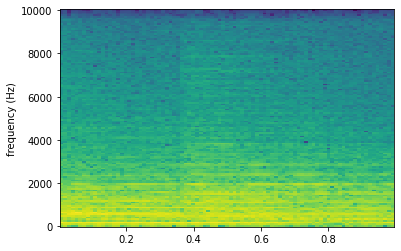

(20000,) -> (129, 89)


In [2]:
def get_spectrogram(sample):
    assert 1 <= len(sample.shape) <= 2
    if len(sample.shape) == 2:
        sample = np.average(sample, axis = 0)
    return sig.spectrogram(sample, UNIFORM_SAMPLE_RATE)

i = train['Bell'][0]
f, t, Sxx = get_spectrogram(i)
plt.pcolormesh(t, f, np.log10(Sxx))
plt.ylabel('frequency (Hz)')
plt.show()
print(f'{i.shape} -> {Sxx.shape}')

In [14]:
LABEL_TO_INT = {}
INT_TO_LABEL = {}
def prep_sample(x):
    f, t, Sxx = get_spectrogram(sample)
    return np.log10(np.maximum(Sxx, 1e-20))
def prep_dataset(data):
    X = []
    Y = []
    for i, (label, samples) in enumerate(data.items()):
        LABEL_TO_INT[label] = i
        INT_TO_LABEL[i] = label
        for sample in samples:
            X.append(prep_sample(sample))
            Y.append(i)
    return np.array(X), np.array(Y)
X_train, Y_train = prep_dataset(train)
X_test, Y_test = prep_dataset(test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2927, 129, 89) (2927,)
(2901, 129, 89) (2901,)


In [36]:
# run this cell to train a vae autoencoder-based embedding of the training data

EMBEDDING_SIZE = 64

class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.c1 = torch.nn.Conv2d(1, 256, kernel_size = (4, 4), stride = 2)
        self.c2 = torch.nn.Conv2d(256, 128, kernel_size = (4, 4), stride = 2)
        self.c3 = torch.nn.Conv2d(128, 64, kernel_size = (4, 4), stride = 2)
        
        self.d1 = torch.nn.Linear(8064, 1024)
        self.d2 = torch.nn.Linear(1024, 512)
        self.d3 = torch.nn.Linear(512, 256)
        self.d4 = torch.nn.Linear(256, 128)

        self.mean = torch.nn.Linear(128, EMBEDDING_SIZE)
        self.logstd = torch.nn.Linear(128, EMBEDDING_SIZE)
    def forward(self, x):
        assert x.shape[1:] == (129, 89)
        relu = torch.nn.LeakyReLU(0.01)
        
        x = x.reshape(x.shape[0], 1, 129, 89)
        x = relu(self.c1(x))
        x = relu(self.c2(x))
        x = relu(self.c3(x))
        
        x = x.reshape(x.shape[0], -1)
        x = relu(self.d1(x))
        x = relu(self.d2(x))
        x = relu(self.d3(x))
        x = relu(self.d4(x))
        
        return self.mean(x), self.logstd(x)

class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.d1 = torch.nn.Linear(EMBEDDING_SIZE, 128)
        self.d2 = torch.nn.Linear(128, 256)
        self.d3 = torch.nn.Linear(256, 512)
        self.d4 = torch.nn.Linear(512, 1024)
        self.d5 = torch.nn.Linear(1024, 2048)
        self.d6 = torch.nn.Linear(2048, 4096)
        self.d7 = torch.nn.Linear(4096, 8192)
        self.d8 = torch.nn.Linear(8192, 11481)
    def forward(self, x):
        assert x.shape[1:] == (EMBEDDING_SIZE,)
        relu = torch.nn.LeakyReLU(0.01)
        
        x = relu(self.d1(x))
        x = relu(self.d2(x))
        x = relu(self.d3(x))
        x = relu(self.d4(x))
        x = relu(self.d5(x))
        x = relu(self.d6(x))
        x = relu(self.d7(x))

        return self.d8(x).reshape(x.shape[0], 129, 89)

print(f'gpu enabled: {torch.cuda.is_available()}')
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

encoder = Encoder().to(device)
decoder = Decoder().to(device)
enc_X_train = X_train
batch_size = 64
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = 1e-6)
def loss_fn(before, after, mean, logstd):
    mse_loss = torch.mean(torch.sum((before - after)**2, axis = 1))
    kldiv_loss = torch.mean(-0.5 * torch.sum(1 + logstd - logstd.exp()**2 - mean**2, axis = 1))
    return mse_loss + kldiv_loss

def do_training_epoch(epoch):
    encoder.train(True)
    decoder.train(True)
    opt.zero_grad()
    
    train_dataset = np.copy(X_train)
    np.random.shuffle(train_dataset)
    losses = []
    for i in range(len(train_dataset) // batch_size):
        before = torch.tensor(train_dataset[i * batch_size : (i + 1) * batch_size]).to(device)
        mean, logstd = encoder.forward(before)
        embed = mean + logstd.exp() * torch.normal(torch.zeros(std.shape), torch.ones(std.shape)).to(device)
        after = decoder.forward(embed)
        loss = loss_fn(before, after, mean, logstd)
        loss.backward()
        opt.step()
        losses.append(loss.item())
        print(f'partial: {loss.item()}')
    print(f'epoch {epoch}: avg loss {np.mean(losses):.4f}')

for i in range(4):
    do_training_epoch(i)

gpu enabled: True


RuntimeError: CUDA out of memory. Tried to allocate 360.00 MiB (GPU 0; 5.80 GiB total capacity; 3.59 GiB already allocated; 125.88 MiB free; 3.74 GiB reserved in total by PyTorch)

In [34]:
import gc
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

In [206]:
# run this cell to train a PCA-based embedding of the training data

EMBEDDING_SIZE = 64

trans = PCA(n_components = EMBEDDING_SIZE)
trans_res = trans.fit_transform(X.reshape(X.shape[0], -1))

print(trans_res.shape)

(2952, 64)


In [211]:
from scipy import stats
def train_cluster_classifier(x, y, *, n_clusters):
    assert x.shape[0] == y.shape[0]
    clusters = x[np.random.choice(len(x), n_clusters)]
    prev_nearest_cluster = np.array([-1 for _ in range(len(x))])
    while True:
        nearest_cluster = np.array([np.argmin(np.sum((clusters - p)**2, axis = 1)) for p in x])
        assert nearest_cluster.shape == prev_nearest_cluster.shape
        if np.all(nearest_cluster == prev_nearest_cluster):
            break
        prev_nearest_cluster = nearest_cluster
        clusters = np.array([ np.mean([x[j] for j in range(len(x)) if nearest_cluster[j] == i], axis = 0) for i in range(len(clusters)) if np.any(nearest_cluster == i) ])
    cluster_labels = np.array([ stats.mode([y[j] for j in range(len(x)) if prev_nearest_cluster[j] == i], keepdims = False)[0] for i in range(len(clusters)) ])
    return clusters, cluster_labels
c, l = train_cluster_classifier(trans_res, Y, n_clusters = 100)
print(c.shape)
print(l)

(100, 64)
[28  1  4 24 29 33  4 19 24 31 16 33 14 24  7 10 25 29  2 12 28 10 28 21
 32 20 12 31 28 14  7 12 14 35 36 30  4 17 32 31  0  8 25 29 15 35 18 29
  7 11 31 11 29 12 17 24  4 36  7 16 10 12 12 15 15 17  4  2 21  2 22 32
 12 22 33 32 25 25  9 12 29  0 31 15  7 24 33  4 13 37 33 31 26 32  1 20
  7 31 29 15]


In [214]:
def cluster_classify(clusters, cluster_labels, value):
    return cluster_labels[np.argmin(np.sum((clusters - value)**2, axis = 1))]

d = train

total = 0
correct = 0
for label, samples in d.items():
    for sample in samples:
        predict = INT_TO_LABEL[cluster_classify(c, l, trans.transform(prep_sample(sample).reshape(1, -1)))]
        if predict == label:
            correct += 1
        total += 1
print(f'accuracy: {correct / total:.2f} ({correct} / {total})')

accuracy: 0.38 (1115 / 2952)


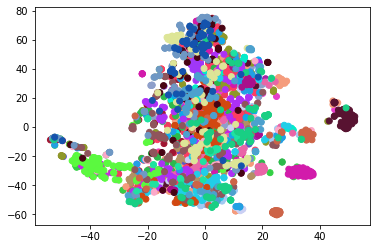

In [105]:
import random
color_map = np.array([[random.random(), random.random(), random.random()] for _ in range(40)])
plt.scatter(trans_res[:,0], trans_res[:,1], c = color_map[Y])